# Mastering policy gradient with Regelum

For theoretical background we kindly refer a reader to our documentation (ToDo link).

In this tutorial we will implement a well-known policy gradient algorithm Vanilla Policy Gradient with General Advantage Estimation.

Moreover, we will create a complex system composed of two different kinematic systems, namely, three wheeled robot and a kinematic point.

Appears that this perfectly represents an environment from a well-known problem, namely, homicidal chauffeur problem.

## Vanilla Policy Gradient.

Our plan is to implement:

1. A pedestrian-chauffeur controlled system with circle boundary
2. Policy VPG objective
3. Stochastic policy
    1. Stochastic model for action sampling
    2. Respective Policy with optimization procedure
4. Critic
5. Proper scenario, running costs and other basic entities needed to construct a pipeline
6. Create suitable callbacks in order to properly log a processing of our pipeline
7. Analyse historical data

In [1]:
from regelum.optimizable.core.configs import TorchOptimizerConfig
from regelum.__internal.base import apply_callbacks
from regelum.policy import Policy
from regelum.scenario import RLScenario
from regelum.data_buffers import DataBuffer
from regelum.callback import (
    Callback,
    HistoricalCallback,
    ScenarioStepLogger,
    HistoricalDataCallback,
    ValueCallback
)
from regelum.system import ComposedSystem, KinematicPoint, ThreeWheeledRobotKinematic
from regelum.objective import RunningObjective
from regelum.critic import Critic
from regelum.model import (
    PerceptronWithTruncatedNormalNoise,
    ModelQuadLin,
    MultiplyByConstant,
    ModelNN,
    ModelPerceptron
)
from regelum.utils import rg
from regelum.simulator import CasADi
from regelum.event import Event
from regelum import set_ipython_env
from regelum.data_buffers.batch_sampler import RollingBatchSampler
from typing import List


import torch as th
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, clear_output

%matplotlib inline

In [2]:
DISCOUNT_FACTOR = 0.95
STATE_INIT: np.ndarray = rg.array([1.0, 1.0, 0.0, 0.0, np.pi / 4])
STATE_NAMING = ["p_x", "p_y", "c_x", "c_y", "c_theta"]
SAMPLING_TIME: float = 0.05
SIM_STEP: float = SAMPLING_TIME
ITERS_AGENT_SWITCH: int = 10
N_EPISODES_IN_ITERATION: int = 3
N_ITERATIONS: int = 200

## Define system

To successfully implement our system we have to define the boundary and dynamics of systems when approaching this boundary

In [3]:
def circle_bound(point):
    return (
        point[0] ** 2 + point[1] ** 2 - 25
    )  # Presume our environment is bounded with a circle of radius 5


class KinematicPointRestricted(KinematicPoint):

    def _compute_state_dynamics(self, time, state, inputs):
        Dstate = super()._compute_state_dynamics(time, state, inputs)
        return rg.if_else(
            circle_bound(state) <= -1e-7,
            Dstate,
            rg.if_else(
                rg.dot(Dstate, state) < 0,
                Dstate,
                rg.zeros(2, prototype=Dstate),
            ),
        )  # When approaching boundary, only can move in directions to the circle interior


class ThreeWheeledRobotKinematicRestricted(ThreeWheeledRobotKinematic):
    def _compute_state_dynamics(self, time, state, inputs):
        Dstate = super()._compute_state_dynamics(time, state, inputs)
        return rg.if_else(
            circle_bound(state[:2]) <= -1e-7,
            Dstate,
            rg.if_else(
                rg.dot(Dstate[:2], state[:2]) < 0,
                Dstate,
                rg.zeros(3, prototype=Dstate),
            ),
        )  # When approaching boundary, only can move in directions to the circle interior


homicidal_chauffeur_system = ComposedSystem(
    sys_left=KinematicPointRestricted(),
    sys_right=ThreeWheeledRobotKinematicRestricted(),
    output_mode="both",
    io_mapping=[],  # means that no output of the left system is used as input to the right one.
    action_bounds=KinematicPoint._action_bounds
    + ThreeWheeledRobotKinematic._action_bounds,
    state_naming=STATE_NAMING,
)  # This concatenated system perfectly suits for homicidal chauffeur modelling

In [4]:
KinematicPointRestricted().compute_state_dynamics(
    None, rg.array([1, 2]), rg.array([1, 1])
)

array([[1., 1.]])

In [5]:
ThreeWheeledRobotKinematicRestricted().compute_state_dynamics(
    None,
    rg.array([0, 0, np.pi / 4], rc_type=rg.CASADI),
    rg.array([1, 0], rc_type=rg.CASADI),
)

DM([[0.707107, 0.707107, 0]])

In [6]:
homicidal_chauffeur_system.compute_state_dynamics(
    None,
    rg.array([0, 0, 0, 0, np.pi / 4], rc_type=rg.CASADI),
    rg.array([1, 1, 1, 0], rc_type=rg.CASADI),
)

DM([[1, 1, 0.707107, 0.707107, 0]])

In [7]:
homicidal_chauffeur_system.compute_state_dynamics(
    None, rg.array_symb((1, 5), literal="s"), rg.array_symb((1, 4), literal="u")
)

MX(@1=s', @2=(((sq(@1[0])+sq(@1[1]))-25)<=-1e-07), @3=u', @4=((zeros(2x1)[0] = @3[0])[1] = @3[1]), @5=(((sq(@1[2])+sq(@1[3]))-25)<=-1e-07), @6=((zeros(2x1)[0] = @3[2])[1] = @3[3]), @7=(((zeros(3x1)[0] = (@6[0]*cos(@1[4])))[1] = (@6[0]*sin(@1[4])))[2] = @6[1]), horzcat(((@2?@4:0)+((!@2)?((dot(@4, @1[:2])<0)?@4:0):0))', ((@5?@7:0)+((!@5)?((dot(@7[:2], @1[2:4])<0)?@7:0):0))'))

## Policy VPG objective

To simplify an implementation we will split it into two parts:
- GAE computation
- VPG objective

In [8]:
def get_gae_advantage(
    gae_lambda: float,
    running_objectives: th.FloatTensor,
    values: th.FloatTensor,
    times: th.FloatTensor,
    discount_factor: float,
    sampling_time: float,
) -> th.FloatTensor:
    deltas = (
        running_objectives[:-1]
        + discount_factor**sampling_time * values[1:]
        - values[:-1]
    )
    if gae_lambda == 0.0:
        advantages = deltas
    else:
        gae_discount_factors = (gae_lambda * discount_factor) ** times[:-1]
        reversed_gae_discounted_deltas = th.flip(
            gae_discount_factors * deltas, dims=[0, 1]
        )
        advantages = (
            th.flip(reversed_gae_discounted_deltas.cumsum(dim=0), dims=[0, 1])
            / gae_discount_factors
        )
    return advantages


def vpg_objective(
    policy_model: PerceptronWithTruncatedNormalNoise,
    critic_model: ModelNN,
    observations: th.FloatTensor,
    actions: th.FloatTensor,
    times: th.FloatTensor,
    episode_ids: th.LongTensor,
    discount_factor: float,
    N_episodes: int,
    running_objectives: th.FloatTensor,
    sampling_time: float,
    is_normalize_advantages: bool,
    gae_lambda: float,
) -> th.FloatTensor:
    critic_values = critic_model(observations)
    log_pdfs = policy_model.log_pdf(observations, actions).reshape(-1)

    objective = 0.0
    for episode_idx in th.unique(episode_ids):
        mask = (episode_ids == episode_idx).reshape(-1)
        advantages = get_gae_advantage(
            gae_lambda=gae_lambda,
            running_objectives=running_objectives[mask],
            values=critic_values[mask],
            times=times[mask],
            discount_factor=discount_factor,
            sampling_time=sampling_time,
        ).reshape(-1)

        if is_normalize_advantages:
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

        objective += (
            discount_factor ** times[mask][:-1].reshape(-1)
            * advantages
            * log_pdfs[mask][:-1]
        ).sum()

    return objective / N_episodes

## Stochastic double-model policy

Now, we define the stochastic policy with two models that should act and be optimized separately.

We will achieve it passing two separate instances of `PerceptronWithTruncatedNormalNoise` and two respective critics into it.

In [9]:
class JointPolicyVPG(Policy):
    def __init__(
        self,
        pedestrian_model: PerceptronWithTruncatedNormalNoise,
        chauffeur_model: PerceptronWithTruncatedNormalNoise,
        pedestrian_critic: Critic,
        chauffeur_critic: Critic,
        system: ComposedSystem,
        is_normalize_advantages: bool = True,
        gae_lambda: float = 0.95,
        N_episodes: int = 1,
        sampling_time: float = 0.1,
    ):
        def freeze_stds(params):
            for p in params():
                if p[0] == "stds":
                    p[1].requires_grad_(False)
            return params  # Detaches parameters named "stds"

        iter_batches_kwargs = {
            "batch_sampler": RollingBatchSampler,
            "dtype": th.FloatTensor,
            "mode": "full",
            "n_batches": 1,
            "device": "cpu",
        }
        super().__init__(
            system=system,
            optimizer_config=TorchOptimizerConfig(
                n_epochs=1,  # Only one grad step
                data_buffer_iter_bathes_kwargs=iter_batches_kwargs,
                opt_method_kwargs=dict(lr=1e-3),
            ),
            action_bounds=system.sys_left.action_bounds
            + system.sys_right.action_bounds,
        )
        self.is_normalize_advantages = is_normalize_advantages
        self.gae_lambda = gae_lambda
        self.pedestrian_model = pedestrian_model
        self.chauffeur_model = chauffeur_model
        self.model_to_optimize = self.pedestrian_model

        self.pedestrian_critic = pedestrian_critic
        self.chauffeur_critic = chauffeur_critic
        self.current_critic = self.pedestrian_critic
        self.N_episodes = N_episodes
        self.sampling_time = sampling_time

        ## Define an optimization problem here

        self.pedestrian_model_weigths = self.create_variable(
            name="pedestrian_model_weights", like=self.pedestrian_model.named_parameters
        )
        self.pedestrian_model_weigths.register_hook(freeze_stds)

        self.chauffeur_model_weights = self.create_variable(
            name="chauffeur_model_weights",
            like=self.chauffeur_model.named_parameters,
            is_constant=True,
        )
        self.chauffeur_model_weights.register_hook(freeze_stds)

        self.objective_inputs = [
            self.create_variable(name=variable_name, is_constant=True)
            for variable_name in self.data_buffer_objective_keys()
        ]
        self.register_objective(
            self.objective_function, variables=self.objective_inputs
        )

    def switch_critic(self):
        # This method will be triggered from Scenario
        self.current_critic = (
            self.pedestrian_critic
            if self.current_critic is self.chauffeur_critic
            else self.chauffeur_critic
        )

    def switch_model_to_optimize(self):
        # This method will be triggered from Scenario
        self.model_to_optimize = (
            self.pedestrian_model
            if self.model_to_optimize is self.chauffeur_model
            else self.chauffeur_model
        )
        return self.model_to_optimize

    def action_col_idx(self):
        return (
            slice(0, self.system.sys_left.dim_inputs)
            if self.model_to_optimize is self.pedestrian_model
            else slice(self.system.sys_right.dim_inputs, None)
        )

    def objective_function(
        self,
        observation: th.Tensor,  # All arguments here will be passed from data buffer
        action: th.Tensor,
        time: th.Tensor,
        episode_id: th.Tensor,
        running_objective: th.Tensor,
    ):
        actions_of_current_model = action[
            :, self.action_col_idx()
        ]  # Choose respective actions
        return vpg_objective(
            policy_model=self.model_to_optimize,
            critic_model=self.current_critic.model,
            observations=observation,
            actions=actions_of_current_model,
            times=time,
            discount_factor=self.discount_factor,
            N_episodes=self.N_episodes,
            episode_ids=episode_id.long(),
            running_objectives=running_objective,
            sampling_time=self.sampling_time,
            is_normalize_advantages=self.is_normalize_advantages,
            gae_lambda=self.gae_lambda,
        )

    def get_action(self, observation: np.array) -> np.array:
        action_pedestrian = self.pedestrian_model(th.FloatTensor(observation))
        action_chauffeur = self.chauffeur_model(th.FloatTensor(observation))
        action = rg.hstack((action_pedestrian, action_chauffeur)).detach().cpu().numpy()
        return action  # Concatenate actions in order to pass them as a whole into Scenario at runtime

    def data_buffer_objective_keys(self):
        return ["observation", "action", "time", "episode_id", "running_objective"]

    @apply_callbacks()
    def optimize(self, data_buffer: DataBuffer) -> None:
        opt_kwargs = data_buffer.get_optimization_kwargs(
            keys=self.data_buffer_objective_keys(),
            optimizer_config=self.optimizer_config,
        )
        super().optimize_tensor(**opt_kwargs)

## Critic

As we will use a common Value critic, we will just instantiate two of them responsible for the pedestrian and chauffeur agent

In [10]:
pedestrian_critic_model = ModelPerceptron(
    dim_input=5,
    dim_output=1,
    dim_hidden=40,
    n_hidden_layers=3,
    hidden_activation=th.nn.Tanh(),
)

chauffeur_critic_model = ModelPerceptron(
    dim_input=5,
    dim_output=1,
    dim_hidden=40,
    n_hidden_layers=3,
    hidden_activation=th.nn.Tanh(),
)

iter_batches_kwargs = {
    "batch_sampler": RollingBatchSampler,
    "dtype": th.FloatTensor,
    "mode": "full",
    "n_batches": 1,
    "device": "cpu",
}

pedestrian_critic_optimizer_config = TorchOptimizerConfig(
    n_epochs=20,
    data_buffer_iter_bathes_kwargs=iter_batches_kwargs,
    opt_method_kwargs=dict(lr=1e-3),
)

chauffeur_critic_optimizer_config = TorchOptimizerConfig(
    n_epochs=20,
    data_buffer_iter_bathes_kwargs=iter_batches_kwargs,
    opt_method_kwargs=dict(lr=1e-3),
)

pedestrian_critic = Critic(
    system=homicidal_chauffeur_system.sys_left,
    model=pedestrian_critic_model,
    td_n=2,
    is_value_function=True,
    is_on_policy=True,
    optimizer_config=pedestrian_critic_optimizer_config,
    discount_factor=DISCOUNT_FACTOR,
)

chauffeur_critic = Critic(
    system=homicidal_chauffeur_system.sys_right,
    model=chauffeur_critic_model,
    td_n=2,
    is_value_function=True,
    is_on_policy=True,
    optimizer_config=chauffeur_critic_optimizer_config,
    discount_factor=DISCOUNT_FACTOR,
)

In [11]:
class PedestrianRunningObjectiveModel(ModelQuadLin):
    def __init__(self, weights=rg.array([10, 0, 0, 0, 0])):
        super().__init__(
            quad_matrix_type="diagonal",
            dim_inputs=4,
            weights=weights,
        )
        self.eps = 1.0e-5

    def __call__(self, *argin, **kwargs):
        observation = argin[0]
        pedestrian_pos = observation[0, :2]
        chauffeur_pos = observation[0, 2:-1]
        distance = rg.norm_2(pedestrian_pos - chauffeur_pos)  # square norm of distance
        inv_distance = rg.array(
            [
                [(1 / (distance + self.eps)) if distance < 2 else 0]
            ]  # We penalize a pedestrian for close distance to the chauffeur
        )
        action = argin[1]
        return super().__call__(inv_distance, action, **kwargs)


class ChauffeurRunningObjectiveModel(ModelQuadLin):
    def __init__(self, weights=rg.array([10, 0, 0, 0, 0])):
        super().__init__(
            quad_matrix_type="diagonal",
            dim_inputs=4,
            weights=weights,
        )

    def __call__(self, *argin, **kwargs):
        observation = argin[0]
        pedestrian_pos = observation[0, :2]
        chauffeur_pos = observation[0, 2:-1]
        distance = rg.array([[rg.norm_2(pedestrian_pos - chauffeur_pos)]])
        action = argin[1]
        return super().__call__(distance, action, **kwargs)


simulator = CasADi(
    system=homicidal_chauffeur_system,
    state_init=STATE_INIT,
    time_final=7,
    max_step=SIM_STEP,
)


class GameScenario(RLScenario):
    def __init__(
        self,
        policy: JointPolicyVPG,
        pedestrian_critic: Critic,
        chauffeur_critic: Critic,
        simulator: CasADi,
        pedestrian_running_objective_model: PedestrianRunningObjectiveModel,
        chauffeur_running_objective_model: ChauffeurRunningObjectiveModel,
        discount_factor: float = DISCOUNT_FACTOR,
        sampling_time: float = SAMPLING_TIME,
        N_iterations: int = 200,
        is_parallel: bool = True,
        iters_to_switch_opt_agent: int = 1,
    ):
        self.pedestrian_running_objective = RunningObjective(
            model=pedestrian_running_objective_model
        )
        self.chauffeur_running_objective = RunningObjective(
            model=chauffeur_running_objective_model
        )
        self.pedestrian_critic = pedestrian_critic
        self.chauffeur_critic = chauffeur_critic

        self.iters_to_switch_opt_agent = iters_to_switch_opt_agent
        super().__init__(
            policy=policy,
            critic=pedestrian_critic,
            running_objective=self.pedestrian_running_objective,
            simulator=simulator,
            policy_optimization_event=Event.reset_iteration,
            discount_factor=discount_factor,
            sampling_time=sampling_time,
            N_episodes=policy.N_episodes,
            N_iterations=N_iterations,
            is_parallel=is_parallel,
            is_critic_first=True,
        )
        self.policy: JointPolicyVPG

    def switch_running_objective(self):
        self.running_objective = (
            self.pedestrian_running_objective
            if self.running_objective is self.chauffeur_running_objective
            else self.chauffeur_running_objective
        )

    def switch_critic(self):
        self.critic = (
            self.pedestrian_critic
            if self.critic is self.chauffeur_critic
            else self.chauffeur_critic
        )

    @apply_callbacks()
    def compute_action_sampled(self, time, estimated_state, observation):
        return super().compute_action_sampled(time, estimated_state, observation)

    @apply_callbacks()  # We will add a callbacks to log it when we switch an optimizing agent
    def switch_optimizing_agent(self):
        self.switch_running_objective()
        policy_weights_to_fix, policy_weights_to_unfix = (
            ["pedestrian_model_weights", "chauffeur_model_weights"]
            if self.running_objective.model is self.chauffeur_running_objective.model
            else ["chauffeur_model_weights", "pedestrian_model_weights"]
        )
        self.policy.fix_variables([policy_weights_to_fix])
        self.policy.unfix_variables([policy_weights_to_unfix])
        self.policy.switch_model_to_optimize()
        self.policy.switch_critic()
        self.switch_critic()
        return policy_weights_to_fix, policy_weights_to_unfix

    def reset_iteration(self):
        super().reset_iteration()
        if self.iteration_counter % self.iters_to_switch_opt_agent == 0:
            self.switch_optimizing_agent()

In [12]:
pedestrian_model = PerceptronWithTruncatedNormalNoise(
    dim_input=5,
    dim_output=2,
    dim_hidden=40,
    n_hidden_layers=3,
    hidden_activation=th.nn.Tanh(),
    output_bounds=homicidal_chauffeur_system.sys_left.action_bounds,
    is_truncated_to_output_bounds=True,
    output_activation=MultiplyByConstant(0.1),
    stds=[0.05] * 2,
)

chauffeur_model = PerceptronWithTruncatedNormalNoise(
    dim_input=5,
    dim_output=2,
    dim_hidden=40,
    n_hidden_layers=3,
    hidden_activation=th.nn.Tanh(),
    output_bounds=homicidal_chauffeur_system.sys_left.action_bounds,
    is_truncated_to_output_bounds=True,
    output_activation=MultiplyByConstant(0.1),
    stds=[0.05] * 2,
)


policy = JointPolicyVPG(
    pedestrian_model=pedestrian_model,
    chauffeur_model=chauffeur_model,
    pedestrian_critic=pedestrian_critic,
    chauffeur_critic=chauffeur_critic,
    system=homicidal_chauffeur_system,
    is_normalize_advantages=True,
    gae_lambda=0.95,
    N_episodes=N_EPISODES_IN_ITERATION,
    sampling_time=SAMPLING_TIME,
)

scenario = GameScenario(
    policy=policy,
    pedestrian_critic=pedestrian_critic,
    chauffeur_critic=chauffeur_critic,
    simulator=simulator,
    pedestrian_running_objective_model=PedestrianRunningObjectiveModel(),
    chauffeur_running_objective_model=ChauffeurRunningObjectiveModel(),
    discount_factor=DISCOUNT_FACTOR,
    sampling_time=SAMPLING_TIME,
    is_parallel=False,  # Logging is not working in parallel mode while in jupyter, so we disable it for now.
    N_iterations=N_ITERATIONS,
    iters_to_switch_opt_agent=ITERS_AGENT_SWITCH,
)

## Implement callbacks

Instead of printing every step we doubt, we can implement callbacks logging and saving interim data for us.

In this particular situation we may be interested in the following:

- Whether the switching between agents performs correctly
- How do the values of our agents evolve over time
- Which object is optimizing currently

Let's implement callbacks which will log these data for us.

In [13]:
class SwitchAgentCallback(Callback):
    def is_target_event(self, obj, method, output, triggers):
        return method == "switch_optimizing_agent"

    def on_function_call(self, obj: GameScenario, method, output):
        clear_output()
        self.log(
            "Optimizing agent switched to"
            f" {'pedestrian' if output[1] == 'pedestrian_model_weights' else 'chauffeur'} "
            f"after iterartion: {obj.iteration_counter}"
        )


class DoubleAgentStepLogger(HistoricalCallback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.cooldown = 0.0
        self.state_components_naming = STATE_NAMING

    def is_target_event(self, obj, method, output, triggers):
        return (method == "post_compute_action") and isinstance(obj, GameScenario)

    def on_function_call(self, obj: GameScenario, method, output):
        self.add_datum(
            {
                **{
                    "time": output["time"],
                    "running_objective_pedestrian": obj.pedestrian_running_objective(
                        output["estimated_state"], output["action"]
                    ),
                    "running_objective_chauffeur": obj.chauffeur_running_objective(
                        output["estimated_state"], output["action"]
                    ),
                    "episode_id": output["episode_id"],
                    "iteration_id": output["iteration_id"],
                },
                **dict(zip(self.state_components_naming, output["estimated_state"][0])),
            }
        )


class WhichOptimizeCallback(Callback):
    def is_target_event(self, obj, method, output, triggers):
        return isinstance(obj, JointPolicyVPG) and method == "optimize"

    def on_function_call(self, obj: JointPolicyVPG, method, output):
        which = (
            "pedestrian"
            if obj.chauffeur_model_weights.is_constant
            else "chauffeur_model"
        )
        self.log(f"A {which} policy updated...")


callbacks = [SwitchAgentCallback, DoubleAgentStepLogger, WhichOptimizeCallback]
callbacks = set_ipython_env(callbacks=callbacks, interactive=True)

## Run it!

In [14]:
scenario.run()  # Takes approximately 6-7 minutes to finish 200 iterations

[15:11:56] INFO     Optimizing agent switched to pedestrian after iterartion: 200                   ]8;id=10481;file:///tmp/ipykernel_45242/2327856449.py\2327856449.py]8;;\:]8;id=338884;file:///tmp/ipykernel_45242/2327856449.py#7\7]8;;\

           INFO     A pedestrian policy updated...                                                 ]8;id=240570;file:///tmp/ipykernel_45242/2327856449.py\2327856449.py]8;;\:]8;id=110566;file:///tmp/ipykernel_45242/2327856449.py#52\52]8;;\

## Analysis of historical data collected

In [15]:
def plot_trajectories(callback, episode_id, iteration_id):
    data = callback.data[
        (callback.data.episode_id == episode_id)
        & (callback.data.iteration_id == iteration_id)
    ][homicidal_chauffeur_system.state_naming[:-1]]
    pedestrian_data = data[homicidal_chauffeur_system.state_naming[:2]]
    chauffeur_data = data[homicidal_chauffeur_system.state_naming[2:-1]]
    plt.scatter(pedestrian_data["p_x"], pedestrian_data["p_y"])
    plt.scatter(chauffeur_data["c_x"], chauffeur_data["c_y"])
    plt.scatter(
        chauffeur_data["c_x"].iloc[-1],
        chauffeur_data["c_y"].iloc[-1],
        c="r",
        label="chauffeur final",
    )
    plt.scatter(
        pedestrian_data["p_x"].iloc[-1],
        pedestrian_data["p_y"].iloc[-1],
        c="g",
        label="pedestrian final",
    )
    plt.legend()

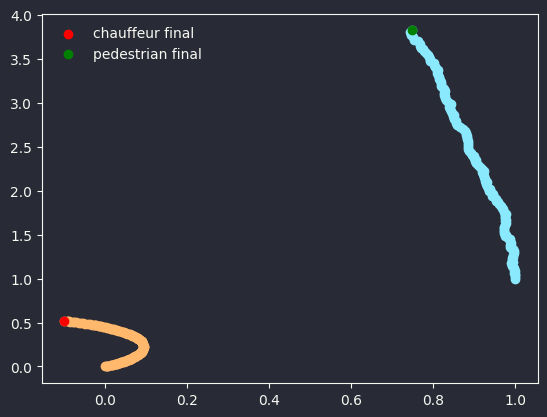

In [16]:
plot_trajectories(callback=callbacks[1], episode_id=1, iteration_id=50)

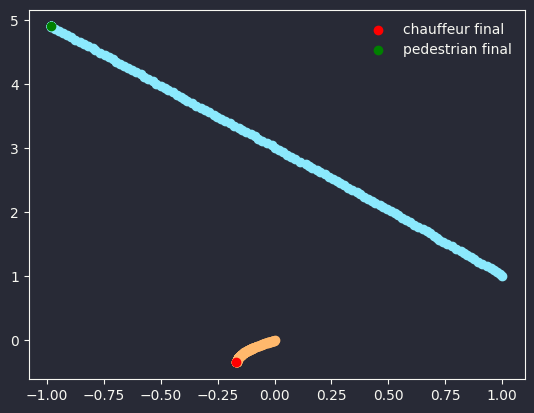

In [17]:
plot_trajectories(callback=callbacks[1], episode_id=1, iteration_id=200)

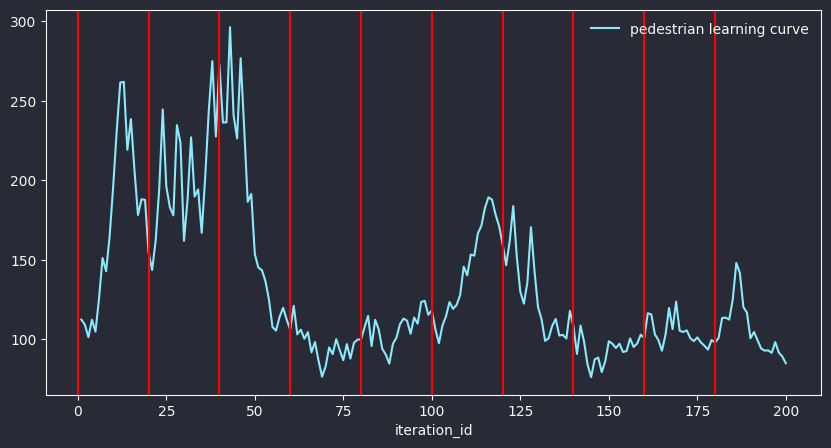

In [18]:
history = callbacks[1].data
history["value_pedestrian"] = history.groupby(["iteration_id", "episode_id"])[
    ["running_objective_pedestrian"]
].cumsum()

mean_iter_values = history.groupby(["iteration_id"])["value_pedestrian"].mean()
mean_iter_values.plot(figsize=(10, 5), label="pedestrian learning curve")


for x in range(0, len(mean_iter_values), ITERS_AGENT_SWITCH * 2):
    plt.axvline(x=x, c="r")  # Plot moments of switching between agents being optimized

plt.legend()

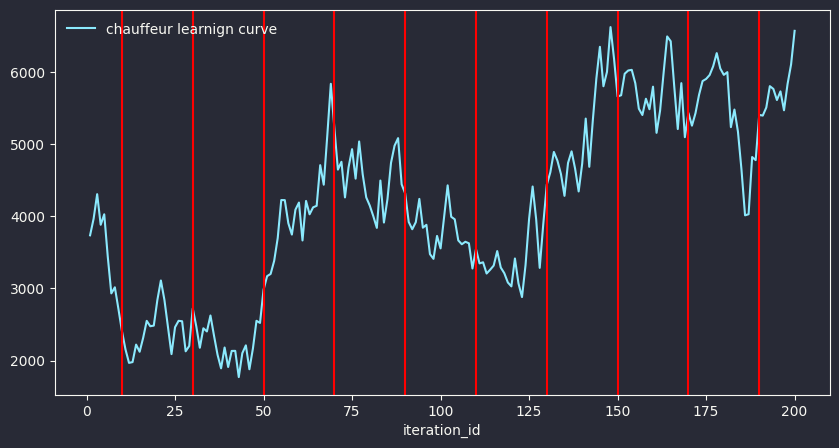

In [19]:
history["value_chauffeur"] = history.groupby(["iteration_id", "episode_id"])[
    ["running_objective_chauffeur"]
].cumsum()

mean_iter_values = history.groupby(["iteration_id"])["value_chauffeur"].mean()
mean_iter_values.plot(figsize=(10, 5), label="chauffeur learnign curve")


for x in range(ITERS_AGENT_SWITCH, len(mean_iter_values), ITERS_AGENT_SWITCH * 2):
    plt.axvline(x=x, c="r")  # Plot moments of switching between agents being optimized

plt.legend()

##